# Calculate RXE for public dataset, females only based on Apua's script

In [1]:
import re
import functools
import numpy as np
import pandas as pd
from os import environ
from plotnine import *
from scipy.stats import variation
from warnings import filterwarnings
from scipy.stats import mannwhitneyu
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [3]:
environ['NUMEXPR_MAX_THREADS'] = '10'

In [4]:
config = {
    'pheno_file': 'cmc_phenotypes.csv',
    'cpm_file': 'cmc_log2tpm.tsv',
    'tpm_file': '/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/counts/gene_tpm/_m/log2tpm.csv',
    'annot_file': 'cmc_gene_annotation.tsv',
}

In [5]:
@functools.lru_cache()
def get_pheno():
    return pd.read_csv(config['pheno_file'], index_col=0)


@functools.lru_cache()
def get_annotation():
    return pd.read_csv(config['annot_file'], index_col=0, sep='\t')


In [6]:
def chrom_type(chrom):
    if chrom=='X':
        return 'X'
    elif re.search('^\d+', chrom):
        return 'autosome'
    else:
        return 'other'
    
    
def save_ggplot(p, fn):
    for ext in ['.pdf', '.png', '.svg']:
        p.save(fn+ext, width=10, height=7)


In [7]:
gene_annot = get_annotation()
gene_annot.head(2)

,ensembl_gene_id,hgnc_symbol,chromosome_name
gene_id,,,
ENSG00000000003.14,ENSG00000000003,TSPAN6,X
ENSG00000000005.5,ENSG00000000005,TNMD,X


In [8]:
gene_annot.shape

(57786, 3)

In [10]:
log2tpm = pd.read_csv(config['tpm_file'], index_col=0, sep=',', engine='c')
log2tpm.iloc[0:2, 0:5]

,MSSM_RNA_BP_PFC_2,MSSM_RNA_BP_PFC_4,MSSM_RNA_BP_PFC_5,MSSM_RNA_BP_PFC_6,MSSM_RNA_BP_PFC_7
gene_id,,,,,
ENSG00000000003.14,1.927755,1.341998,1.531728,1.565244,2.178456
ENSG00000000005.5,0.089456,0.036288,0.030684,0.088621,0.235076


In [11]:
log2tpm.shape

(50689, 606)

In [12]:
df0 = gene_annot.merge(log2tpm, right_index=True, left_index=True).drop_duplicates(subset=['ensembl_gene_id'])
df0.shape

(50116, 609)

In [13]:
df0['chrom_type'] = df0['chromosome_name'].apply(chrom_type)
df0.shape

(50116, 610)

In [14]:
df0.groupby('chrom_type').size()

chrom_type
X            1973
autosome    47634
other         509
dtype: int64

In [15]:
samples = np.array(log2tpm.columns[log2tpm.columns.str.contains("RNA|CMC", regex=True)])
df = df0[(df0[samples].sum(axis=1) >= 0.2 * len(samples)) & (df0['chrom_type'] != 'other')]
df1  = df.groupby('chrom_type').mean().transpose()
df1['sample'] = df1.index
df1['RXE'] = df1['X'] - df1['autosome']
df1.head(2)

chrom_type,X,autosome,sample,RXE
MSSM_RNA_BP_PFC_2,2.200046,2.123956,MSSM_RNA_BP_PFC_2,0.076090
MSSM_RNA_BP_PFC_4,1.666547,1.628119,MSSM_RNA_BP_PFC_4,0.038429


In [16]:
df2 = df1.merge(get_pheno(), left_index=True, right_index=True)
df2.head(2)

,X,autosome,sample,RXE,Individual_ID,Institution,Reported_Gender,Dx,Age_of_Death
MSSM_RNA_PFC_1,2.593434,2.529137,MSSM_RNA_PFC_1,0.064297,CMC_MSSM_025,MSSM,Male,SCZ,68.0
MSSM_RNA_PFC_2,2.671583,2.594232,MSSM_RNA_PFC_2,0.077351,CMC_MSSM_136,MSSM,Male,Control,76.0


In [17]:
df2.loc[:, ['Reported_Gender', 'Institution', 'RXE']].groupby(["Institution", 'Reported_Gender']).describe()

RXE                                          \
                             count      mean       std       min       25%   
Institution Reported_Gender                                                  
MSSM        Female           126.0  0.064452  0.067471 -0.091223  0.011314   
            Male             181.0  0.057084  0.061493 -0.123864  0.028780   
Penn        Female            54.0  0.087981  0.050013 -0.061658  0.056191   
            Male              40.0  0.086565  0.060443 -0.054610  0.052106   
Pitt        Female            41.0  0.096361  0.031602  0.035355  0.072419   
            Male             106.0  0.086847  0.038292  0.013630  0.061782   

                                                           
                                  50%       75%       max  
Institution Reported_Gender                                
MSSM        Female           0.077272  0.108856  0.252011  
            Male             0.069662  0.098850  0.191223  
Penn        Female           0.087779  0.117958  0.237269  
            Male             0.089127  0.114203  0.241984  
Pitt        Female           0.095637  0.125129  0.155254  
            Male             0.083307  0.113255  0.183857

In [18]:
for institution in df2.Institution.unique():
    for sex in ["Female", "Male"]:
        var = variation(df2[(df2['Institution']==institution) & 
                            (df2['Reported_Gender']==sex)].RXE)
        print("There is %.3f variation for %s in %s." % (var, sex, institution))

There is 1.043 variation for Female in MSSM.
There is 1.074 variation for Male in MSSM.
There is 0.563 variation for Female in Penn.
There is 0.689 variation for Male in Penn.
There is 0.324 variation for Female in Pitt.
There is 0.439 variation for Male in Pitt.


In [19]:
df2.loc[:, ['Reported_Gender', 'Institution', 'RXE']].groupby(['Reported_Gender']).describe()

RXE                                                    \
                 count      mean       std       min       25%       50%   
Reported_Gender                                                            
Female           221.0  0.076121  0.059662 -0.091223  0.046247  0.084960   
Male             327.0  0.070338  0.056707 -0.123864  0.043616  0.076682   

                                     
                      75%       max  
Reported_Gender                      
Female           0.112245  0.252011  
Male             0.105211  0.241984

In [20]:
for sex in ["Female", "Male"]:
    var = variation(df2[(df2['Reported_Gender']==sex)].RXE)
    print("There is %.3f variation for %s." % (var, sex)) # Not sure if this variation is real

There is 0.782 variation for Female.
There is 0.805 variation for Male.


### Separate out tissues

In [21]:
for institution in df2.Institution.unique():
    dft = df2[(df2['Institution'] == institution)].copy()
    stat, pval = mannwhitneyu(dft[(dft['Reported_Gender']=="Female")].RXE,
                              dft[(dft['Reported_Gender']=="Male")].RXE)
    print("Mann-WhitneyU for female vs male (RXE) for %s: %.4f" % (institution, pval))

Mann-WhitneyU for female vs male (RXE) for MSSM: 0.1465
Mann-WhitneyU for female vs male (RXE) for Penn: 0.4347
Mann-WhitneyU for female vs male (RXE) for Pitt: 0.0639


In [22]:
stat, pval = mannwhitneyu(df2[(df2['Reported_Gender']=="Female")].RXE,
                          df2[(df2['Reported_Gender']=="Male")].RXE)
print("Mann-WhitneyU for female vs male (RXE) for %s: %.4f, %.1f" % ("DLPFC", pval, stat))

Mann-WhitneyU for female vs male (RXE) for DLPFC: 0.0668


In [27]:
for institution in df2.Institution.unique():
    dft = df2[(df2['Institution'] == institution)].copy()
    stat, pval = mannwhitneyu(dft[(dft['Dx']=='Control')].RXE, 
                              dft[(dft['Dx']=='SCZ')].RXE)
    print("Mann-WhitneyU for ctl vs sz (RXE) for %s: %.4e" % (institution, pval))

Mann-WhitneyU for ctl vs sz (RXE) for MSSM: 1.6856e-02
Mann-WhitneyU for ctl vs sz (RXE) for Penn: 1.5906e-01
Mann-WhitneyU for ctl vs sz (RXE) for Pitt: 1.6895e-01


In [26]:
stat, pval = mannwhitneyu(df2[(df2['Dx']=="Control")].RXE,
                          df2[(df2['Dx']=="SCZ")].RXE)
print("Mann-WhitneyU for female vs male (RXE) for %s: %.4e, %.1f" % ("DLPFC", pval, stat))

Mann-WhitneyU for female vs male (RXE) for DLPFC: 3.1961e-02


In [28]:
for institution in df2.Institution.unique():
    dft = df2[(df2['Institution'] == institution)].copy()
    female = dft[(dft['Reported_Gender']=='Female')].copy()
    male = dft[(dft['Reported_Gender']=='Male')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].RXE, 
                                  female[(female['Dx']=='SCZ')].RXE)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].RXE, 
                                  male[(male['Dx']=='SCZ')].RXE)
    print("Mann-WhitneyU of female, ctl vs sz (RXE) for %s: %.4f" % (institution, pval_f))
    print("Mann-WhitneyU of male, ctl vs sz (RXE) for %s: %.4f" % (institution, pval_m))

Mann-WhitneyU of female, ctl vs sz (RXE) for MSSM: 0.1266
Mann-WhitneyU of male, ctl vs sz (RXE) for MSSM: 0.0520
Mann-WhitneyU of female, ctl vs sz (RXE) for Penn: 0.3124
Mann-WhitneyU of male, ctl vs sz (RXE) for Penn: 0.0294
Mann-WhitneyU of female, ctl vs sz (RXE) for Pitt: 0.2924
Mann-WhitneyU of male, ctl vs sz (RXE) for Pitt: 0.1202


In [29]:
female = df2[(df2['Reported_Gender']=='Female')].copy()
male = df2[(df2['Reported_Gender']=='Male')].copy()
stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].RXE, 
                                  female[(female['Dx']=='SCZ')].RXE)
stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].RXE, 
                                  male[(male['Dx']=='SCZ')].RXE)
print("Mann-WhitneyU of female, ctl vs sz (RXE) for %s: %.4f, %.2f" % ("DLPFC", pval_f, stat_f))
print("Mann-WhitneyU of male, ctl vs sz (RXE) for %s: %.4f, %.2f" % ("DLPFC", pval_m, stat_m))

Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.2115
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.0504


### Interaction model

In [30]:
df2.Reported_Gender = df2.Reported_Gender.astype("category").cat.reorder_categories(["Female", "Male"], ordered=True)
df2.Dx = df2.Dx.astype("category").cat.rename_categories({"SCZ": "SZ", "Control": "CTL"})
df2.head(2)

,X,autosome,sample,RXE,Individual_ID,Institution,Reported_Gender,Dx,Age_of_Death
MSSM_RNA_PFC_1,2.593434,2.529137,MSSM_RNA_PFC_1,0.064297,CMC_MSSM_025,MSSM,Male,SZ,68.0
MSSM_RNA_PFC_2,2.671583,2.594232,MSSM_RNA_PFC_2,0.077351,CMC_MSSM_136,MSSM,Male,CTL,76.0


In [31]:
df3 = df2.loc[:, ['RXE', 'Reported_Gender', "Dx", 'Institution']]
df3.loc[:, "Reported_Gender"] = df3.Reported_Gender.cat.codes
df3.Dx = df3.Dx.cat.codes
df3.loc[:, "Institution"] = df3.Institution.astype("category").cat.codes
df3.head(2)

,RXE,Reported_Gender,Dx,Institution
MSSM_RNA_PFC_1,0.064297,1,1,0
MSSM_RNA_PFC_2,0.077351,1,0,0


In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_df = df2.loc[:,['RXE','Reported_Gender', "Dx", 'Institution']]

# ANOVA results with combinations of 2 groups:
formula = 'RXE ~ C(Reported_Gender) + C(Dx) + C(Institution) + C(Reported_Gender):C(Dx) + C(Reported_Gender):C(Institution) + C(Dx):C(Institution)'
lm = ols(formula, anova_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                     sum_sq     df          F        PR(>F)
C(Reported_Gender)                 0.003124    1.0   0.989977  3.201953e-01
C(Dx)                              0.008015    1.0   2.540253  1.115643e-01
C(Institution)                     0.110131    2.0  17.452435  4.531437e-08
C(Reported_Gender):C(Dx)           0.000422    1.0   0.133855  7.146118e-01
C(Reported_Gender):C(Institution)  0.000782    2.0   0.123878  8.835131e-01
C(Dx):C(Institution)               0.013091    2.0   2.074470  1.266267e-01
Residual                           1.697487  538.0        NaN           NaN


#### There is a massive difference between institutions, but no interaction between institution and sex or sex and diagnosis

### Plot RXE

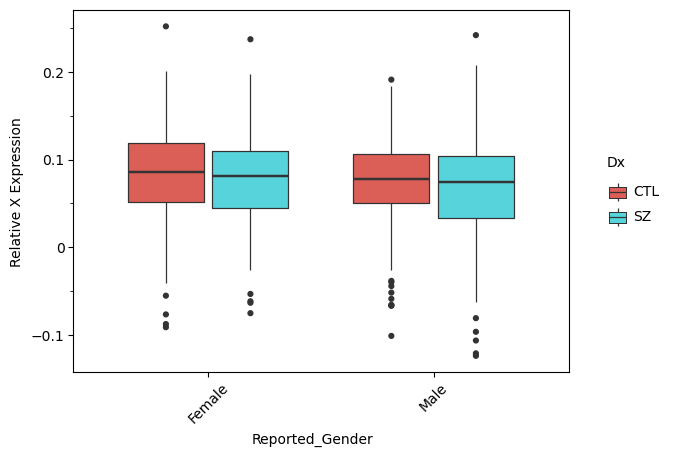

<ggplot: (8771964066166)>

In [33]:
p = ggplot(df2, aes(x='Reported_Gender', y='RXE', fill='Dx')) \
+ geom_boxplot()\
+ ylab("Relative X Expression")\
+ theme_matplotlib()
p + theme(axis_text_x = element_text(angle = 45))

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


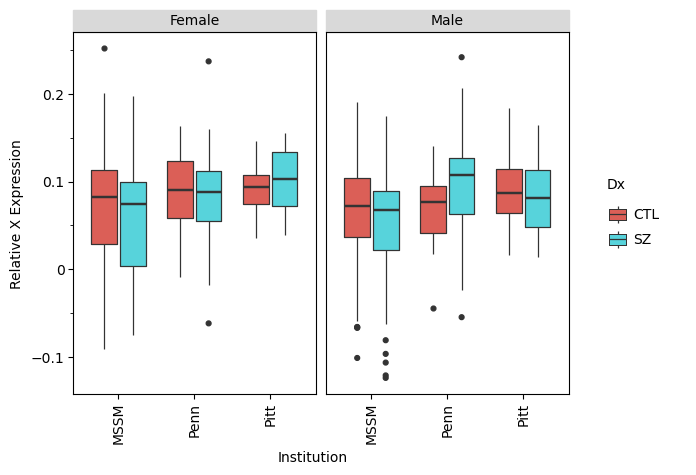

<ggplot: (8771964066121)>

In [34]:
p = ggplot(df2, aes(x='Institution', y='RXE', fill='Dx')) \
+ geom_boxplot()\
+ ylab("Relative X Expression")\
+ facet_grid("~Reported_Gender")\
+ theme_matplotlib()
p + theme(axis_text_x = element_text(angle = 90))

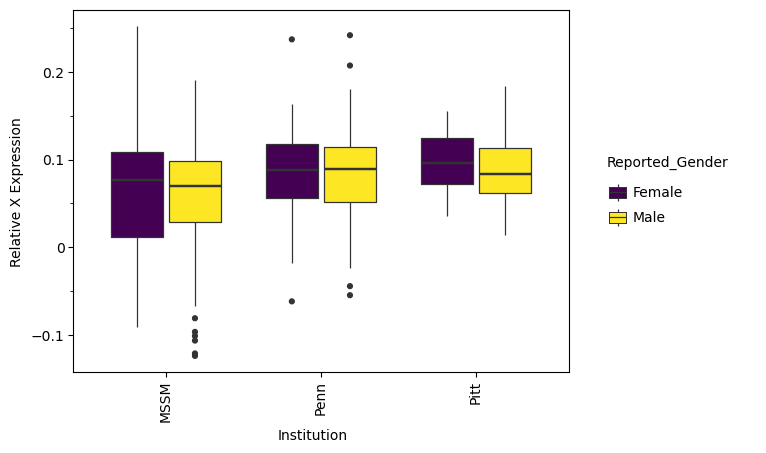

<ggplot: (8771965471130)>

In [35]:
p = ggplot(df2, aes(x='Institution', y='RXE', fill='Reported_Gender')) \
+ geom_boxplot()\
+ ylab("Relative X Expression")\
+ theme_matplotlib()
p + theme(axis_text_x = element_text(angle = 90))

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


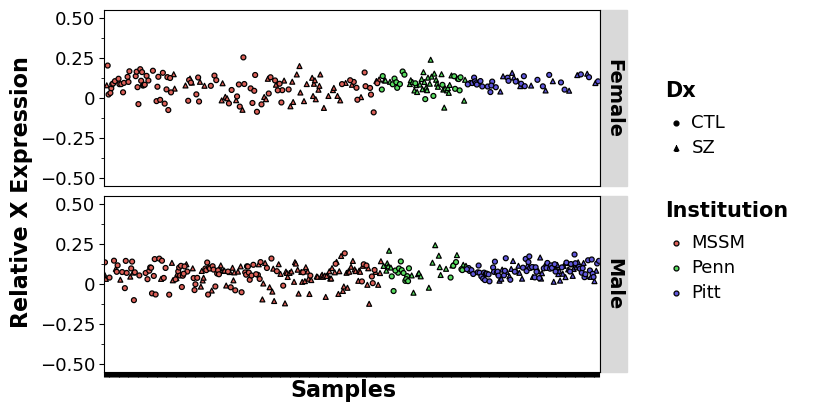

<ggplot: (8771965135945)>

In [36]:
p = ggplot(df2, aes(x='sample', y='RXE', shape="Dx", fill='Institution')) \
+ geom_point() + ylim([-0.5, 0.5]) + xlab("Samples")\
+ ylab("Relative X Expression") + facet_grid("Reported_Gender~.")\
+ theme_matplotlib() \
+ theme(axis_text_x=element_blank(), 
        axis_text=element_text(size=13), 
        legend_title=element_text(size=15, face="bold"), 
        legend_text=element_text(size=13),
        axis_title=element_text(size=16, face="bold"), 
        strip_text=element_text(size=14, face="bold"))
p

In [46]:
df2.to_csv('RXE_public.csv')
save_ggplot(p, "RXE_public_bySex")